In [1]:
!pip install selfeeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.8/122.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-1

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import time
import os
import math
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from datetime import datetime, timedelta


# Import selfeeg for SimCLR implementation
import selfeeg.ssl as ssl
from selfeeg.ssl import SimCLR
# Fixed import for simclr_loss instead of NTXentLoss directly
from selfeeg.losses import simclr_loss


In [3]:
# Constants
BATCH_SIZE = 32  # Reduced batch size for better stability
NUM_WORKERS = 4  # Increased workers for faster data loading
PROJECTION_DIM = 512  # Increased projection dimension
TEMPERATURE = 0.07  # Lower temperature for sharper focus on positive pairs
BASE_LR = 0.0005  # Lower learning rate
WARMUP_EPOCHS = 10  # Add warmup
PRETRAINING_EPOCHS = 2  # More pretraining epochs
NUM_CLASSES = 6
WEIGHT_DECAY = 1e-4  # Add weight decay for regularization

# Create directory for saving models
os.makedirs('models', exist_ok=True)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Setup dataset
BASE_DIR = "/kaggle/input/hms-harmful-brain-activity-classification/"

brain_activities = ['Seizure', 'GPD', 'LRDA', 'Other', 'GRDA', 'LPD']
activity_mapping = {activity: idx for idx, activity in enumerate(brain_activities)}

df = pd.read_csv(f"{BASE_DIR}train.csv")
# df = df.sample(frac=0.01, random_state=42)
# copy_df = df.copy()

# cols_to_check = ['seizure_vote', 'lpd_vote','gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
# copy_df['total_votes'] = copy_df[cols_to_check].sum(axis=1)

# # Get the column with max vote
# copy_df['max_column'] = copy_df[cols_to_check].apply(lambda row: row.idxmax(), axis=1)

# toy = False
# # Use numpy advanced indexing to get max value per row
# row_idx = np.arange(len(copy_df))
# col_idx = copy_df['max_column']
# max_vals = copy_df[cols_to_check].to_numpy()[row_idx, copy_df[cols_to_check].columns.get_indexer(col_idx)]

# copy_df['confidence'] = max_vals / copy_df['total_votes']

# df = copy_df[copy_df['confidence'] == 1.0].drop(['total_votes', 'max_column', 'confidence'], axis=1)

# toy_df = df.sample(frac=0.4, random_state=42)

# # Split 80% Train, 20% Temp (Validation + Test)
# if(toy):
#     train_df, temp_df = train_test_split(toy_df, test_size=0.2, random_state=42)
# else:
#     train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)   

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
# Split 10% Validation, 10% Test from Temp
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# class_counts = train_df['expert_consensus'].value_counts()
# print("Original class distribution:", class_counts.to_dict())

# # Calculate the average class count (rounded to integer)
# avg_count = int(class_counts.mean())
# print(f"Average class count: {avg_count}")

# # Create a balanced dataset by adjusting each class to the average count
# balanced_train_df = pd.DataFrame()

# for class_label, group in train_df.groupby('expert_consensus'):
#     if len(group) > avg_count:
#         # Undersample to average count
#         balanced_group = group.sample(avg_count, random_state=42)
#     elif len(group) < avg_count:
#         # Oversample to average count
#         oversampled = group.sample(avg_count - len(group), replace=True, random_state=42)
#         balanced_group = pd.concat([group, oversampled])
#     else:
#         balanced_group = group
    
#     balanced_train_df = pd.concat([balanced_train_df, balanced_group])

# # Shuffle the balanced dataframe
# balanced_train_df = balanced_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# # Verify the new class distribution
# new_class_counts = balanced_train_df['expert_consensus'].value_counts()
# print("Balanced class distribution:", new_class_counts.to_dict())

# # Save the balanced dataframe
# balanced_train_df.to_csv("train.csv", index=False)

train_df.to_csv("train.csv", index=False)
val_df.to_csv("validation.csv", index=False)
test_df.to_csv("test.csv", index=False)

print("Splitting done with balanced training data!")
print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))


Using device: cuda
Splitting done with balanced training data!
Train: 85440 Val: 10680 Test: 10680


In [4]:
class BrainActivityDataset(Dataset):
    def __init__(self, csv_file, base_dir, activity_mapping, transform=None):
        self.df = csv_file
        self.base_dir = base_dir
        self.activity_mapping = activity_mapping
        self.transform = transform if transform else transforms.Resize((224, 224))
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        spect_id, label, offset = self.df.iloc[idx][["spectrogram_id", "expert_consensus", "spectrogram_label_offset_seconds"]]
        
        # Load and preprocess spectrogram
        temp_df = pd.read_parquet(f'{self.base_dir}/train_spectrograms/{spect_id}.parquet')
        temp_df.drop(['time'], axis=1, inplace=True)
        
        # Extract window
        start = int(offset) // 2
        temp_df = temp_df[start:start+300]
        
        # Log transform and normalization
        temp_df = np.log1p(temp_df)
        temp_df /= temp_df.max()
        temp_arr = np.nan_to_num(temp_df.to_numpy(), nan=1e-4)
        
        # Convert to colormap image
        temp_arr_uint8 = np.uint8(255 * temp_arr)
        rgb_image = cv2.applyColorMap(temp_arr_uint8, cv2.COLORMAP_JET)
        rgb_image = rgb_image.astype(np.float32) / 255.0
        rgb_tensor = torch.tensor(rgb_image).permute(2, 0, 1)  # (C, H, W)
        
        if self.transform:
            rgb_tensor = self.transform(rgb_tensor)
        
        # Create target tensor - for SVM, we'll just need the class index
        y = self.activity_mapping[label]
        
        return rgb_tensor, y

class TensorAugmentation(nn.Module):
    def __init__(self):
        super(TensorAugmentation, self).__init__()
        # Core augmentations
        self.jitter = transforms.ColorJitter(brightness=0.3, contrast=0.4, saturation=0.4, hue=0.2)
        self.resize_crop = transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1))
        self.flip = transforms.RandomHorizontalFlip(p=0.5)
        self.gaussian_blur = transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
        # EEG-specific augmentations
        self.freq_mask = lambda x: self._frequency_masking(x, max_width=40, num_masks=3)
        self.time_mask = lambda x: self._time_masking(x, max_width=40, num_masks=3)
        self.amplitude_scaling = lambda x: self._amplitude_scaling(x, scale_range=(0.8, 1.2))
        self.gaussian_noise = lambda x: self._add_gaussian_noise(x, mean=0.0, std=0.05)
        self.cutmix = lambda x: self._cutmix(x, num_cuts=2, size_range=(10, 30))
        
    def _frequency_masking(self, x, max_width=40, num_masks=3):
        """Apply frequency masking to spectrogram"""
        size = x.size()
        if len(size) == 4:  # [batch, channels, height, width]
            _, _, h, w = size
        else:  # [channels, height, width]
            _, h, w = size
        
        for _ in range(num_masks):
            if torch.rand(1).item() > 0.3:  # Apply with 70% probability
                f_width = int(torch.rand(1).item() * max_width)
                f_start = int(torch.rand(1).item() * (h - f_width))
                if len(size) == 4:
                    x[:, :, f_start:f_start + f_width, :] = 0
                else:
                    x[:, f_start:f_start + f_width, :] = 0
        return x
    
    def _time_masking(self, x, max_width=40, num_masks=3):
        """Apply time masking to spectrogram"""
        size = x.size()
        if len(size) == 4:  # [batch, channels, height, width]
            _, _, h, w = size
        else:  # [channels, height, width]
            _, h, w = size
        
        for _ in range(num_masks):
            if torch.rand(1).item() > 0.3:  # Apply with 70% probability
                t_width = int(torch.rand(1).item() * max_width)
                t_start = int(torch.rand(1).item() * (w - t_width))
                if len(size) == 4:
                    x[:, :, :, t_start:t_start + t_width] = 0
                else:
                    x[:, :, t_start:t_start + t_width] = 0
        return x
    
    def _amplitude_scaling(self, x, scale_range=(0.8, 1.2)):
        """Apply random amplitude scaling"""
        if torch.rand(1).item() > 0.5:  # 50% probability
            scale = torch.FloatTensor(1).uniform_(*scale_range).item()
            x = x * scale
        return x
    
    def _add_gaussian_noise(self, x, mean=0.0, std=0.05):
        """Add random Gaussian noise"""
        if torch.rand(1).item() > 0.5:  # 50% probability
            noise = torch.randn_like(x) * std + mean
            x = x + noise
            x = torch.clamp(x, 0.0, 1.0)  # Keep values in valid range
        return x
    
    def _cutmix(self, x, num_cuts=2, size_range=(10, 30)):
        """Randomly replace rectangular sections with zeros (more aggressive than masking)"""
        if torch.rand(1).item() > 0.7:  # 30% probability - more aggressive augmentation
            size = x.size()
            if len(size) == 4:  # [batch, channels, height, width]
                _, _, h, w = size
            else:  # [channels, height, width]
                _, h, w = size
                
            for _ in range(num_cuts):
                cut_h = int(torch.FloatTensor(1).uniform_(*size_range).item())
                cut_w = int(torch.FloatTensor(1).uniform_(*size_range).item())
                
                cut_h_start = int(torch.rand(1).item() * (h - cut_h))
                cut_w_start = int(torch.rand(1).item() * (w - cut_w))
                
                if len(size) == 4:
                    x[:, :, cut_h_start:cut_h_start + cut_h, cut_w_start:cut_w_start + cut_w] = 0
                else:
                    x[:, cut_h_start:cut_h_start + cut_h, cut_w_start:cut_w_start + cut_w] = 0
        return x
    
    def forward(self, x):
        x = self.resize_crop(x)
        
        # Apply EEG-specific augmentations
        x = self.freq_mask(x)
        x = self.time_mask(x)
        x = self.amplitude_scaling(x)
        x = self.gaussian_noise(x)
        x = self.cutmix(x)
            
        # Apply standard augmentations
        if torch.rand(1).item() > 0.3:
            x = self.flip(x)
            
        if torch.rand(1).item() > 0.3:
            x = self.jitter(x)
            
        if torch.rand(1).item() > 0.5:
            x = self.gaussian_blur(x)
            
        x = self.normalize(x)
        return x

def get_lr_scheduler(optimizer, warmup_epochs, total_epochs):
    """Create learning rate scheduler with warmup"""
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return max(1e-8, float(epoch) / float(max(1, warmup_epochs)))
        else:
            return 0.3 * (1. + math.cos(math.pi * float(epoch - warmup_epochs) / float(max(1, total_epochs - warmup_epochs))))

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def get_class_weights(df, activity_mapping):
    """Calculate class weights to handle imbalance"""
    class_counts = df['expert_consensus'].value_counts().to_dict()
    total_samples = sum(class_counts.values())
    
    weights = []
    for activity in brain_activities:
        count = class_counts.get(activity, 0)
        # Inverse frequency weighting with smoothing
        weight = total_samples / (len(class_counts) * max(1, count))
        weights.append(weight)
    
    # Normalize weights
    total_weight = sum(weights)
    weights = [w / total_weight * len(weights) for w in weights]
    
    return torch.FloatTensor(weights)

class ProjectionHead(nn.Module):
    """
    Enhanced projection head for SimCLR with configurable architecture.
    
    Features:
    - Multi-layer non-linear design
    - Configurable dimensions
    - Optional bottleneck structure
    - L2 normalization
    """
    def __init__(
        self, 
        input_dim, 
        hidden_dim=None, 
        output_dim=128, 
        num_layers=2,
        use_bn=True,
        bottleneck=False,
        normalize_output=True
    ):
        """
        Args:
            input_dim: Input dimension (encoder output dimension)
            hidden_dim: Hidden dimension (if None, will use input_dim)
            output_dim: Output dimension (projection dimension)
            num_layers: Number of layers in projection head
            use_bn: Whether to use BatchNorm
            bottleneck: Whether to use bottleneck structure (narrower hidden layers)
            normalize_output: Whether to L2 normalize the output
        """
        super().__init__()
        
        self.normalize_output = normalize_output
        
        # Configure dimensions
        if hidden_dim is None:
            if bottleneck:
                hidden_dim = input_dim // 2  # Bottleneck structure
            else:
                hidden_dim = input_dim  # Preserve dimensions
        
        layers = []
        
        # First layer
        layers.append(nn.Linear(input_dim, hidden_dim, bias=not use_bn))
        if use_bn:
            layers.append(nn.BatchNorm1d(hidden_dim))
        layers.append(nn.ReLU(inplace=True))
        
        # Middle layers (if any)
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim, bias=not use_bn))
            if use_bn:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU(inplace=True))
        
        # Final layer
        layers.append(nn.Linear(hidden_dim, output_dim, bias=not use_bn))
        if use_bn:
            layers.append(nn.BatchNorm1d(output_dim))
            
        self.projection = nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.projection(x)
        if self.normalize_output:
            x = torch.nn.functional.normalize(x, dim=1)
        return x

def extract_features(model, data_loader, device):
    """Extract features from the encoder for all samples in the data loader"""
    model.eval()
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            features = model(images)
            all_features.append(features.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    return np.vstack(all_features), np.concatenate(all_labels)

def evaluate_svm(svm_model, features, true_labels):
    """Evaluate SVM model performance"""
    predictions = svm_model.predict(features)
    
    # Calculate accuracy
    accuracy = (predictions == true_labels).mean() * 100
    
    # Create confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    
    return {
        'accuracy': accuracy,
        'predictions': predictions,
        'labels': true_labels,
        'confusion_matrix': cm
    }



In [5]:
def train_advanced_svm(train_features, train_labels, val_features, val_labels):
    """
    Train SVM without KFold cross-validation, printing metrics for each hyperparameter combination.
    
    Args:
        train_features: Features extracted from training set
        train_labels: Labels for training set
        val_features: Features extracted from validation set
        val_labels: Labels for validation set
    
    Returns:
        The best SVM model
    """
    from sklearn.svm import SVC
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import ParameterGrid
    from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report
    import joblib
    import os
    
    print("Training SVM classifier without KFold...")
    
    # Check for existing model
    if os.path.exists('models/best_svm_model.pkl'):
        print("Loading existing SVM model...")
        best_pipeline = joblib.load('models/best_svm_model.pkl')
        val_pred = best_pipeline.predict(val_features)
        val_acc = balanced_accuracy_score(val_labels, val_pred)
        print(f"Loaded SVM validation accuracy: {val_acc:.4f}")
        return best_pipeline
    
    # Create pipeline with preprocessing
    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_features)
    val_features_scaled = scaler.transform(val_features)
    
    # Define parameter grid
    param_grid = {
        'C': [45],
        'gamma': ['scale'],
        'kernel': ['rbf'],
        'class_weight': ['balanced']
    }
    
    best_model = None
    best_score = 0
    best_params = None
    
    print(f"\nTesting {len(list(ParameterGrid(param_grid)))} parameter combinations:")
    print("=" * 80)
    
    # Test each parameter combination
    for i, params in enumerate(ParameterGrid(param_grid)):
        print(f"\n--- Test {i+1}: {params} ---")
        
        # Create and train SVM with current parameters
        svm = SVC(**params)
        svm.fit(train_features_scaled, train_labels)
        
        # Make predictions on validation set
        val_pred = svm.predict(val_features_scaled)
        
        # Calculate metrics
        val_acc = balanced_accuracy_score(val_labels, val_pred)
        val_f1 = f1_score(val_labels, val_pred, average='macro')
        
        # Print detailed classification report
        print("\nClassification Report:")
        print(classification_report(val_labels, val_pred))
        print(f"Balanced Accuracy: {val_acc:.4f}")
        print(f"F1-Macro Score: {val_f1:.4f}")
        
        # Track best model
        if val_acc > best_score:
            best_score = val_acc
            best_model = svm
            best_params = params
            print("*** NEW BEST MODEL ***")
        
        print("-" * 50)
    
    # Create final pipeline with best model
    best_pipeline = Pipeline([
        ('scaler', scaler),
        ('svm', best_model)
    ])
    
    print(f"\nBest parameters: {best_params}")
    print(f"Best validation balanced accuracy: {best_score:.4f}")
    
    # Save the best model
    os.makedirs('models', exist_ok=True)
    joblib.dump(best_pipeline, 'models/best_svm_model.pkl')
    print("Best model saved to 'models/best_svm_model.pkl'")
    
    return best_pipeline


In [6]:
def calculate_model_uncertainty(svm_model, features, labels=None, n_bootstrap=100, return_detailed=False):

    import numpy as np
    from sklearn.utils import resample
    from sklearn.base import clone
    import warnings
    warnings.filterwarnings('ignore')
    
    # Convert torch tensor to numpy if needed
    if hasattr(features, 'cpu'):
        features = features.cpu().numpy()
    if labels is not None and hasattr(labels, 'cpu'):
        labels = labels.cpu().numpy()
    
    n_samples = features.shape[0]
    
    # Get the actual SVM model from pipeline if needed
    if hasattr(svm_model, 'named_steps'):
        # It's a pipeline
        actual_svm = svm_model.named_steps['svm']
        # Transform features through the pipeline preprocessing
        features_transformed = svm_model.named_steps['scaler'].transform(features)
    else:
        actual_svm = svm_model
        features_transformed = features
    
    print(f"Calculating uncertainty for {n_samples} samples...")
    
    # 1. Get base predictions and probabilities
    predictions = svm_model.predict(features)
    
    # Try to get probabilities (works if SVM was trained with probability=True)
    try:
        probabilities = svm_model.predict_proba(features)
        has_probabilities = True
    except:
        print("Warning: SVM was not trained with probability=True. Using decision function instead.")
        probabilities = None
        has_probabilities = False
    
    # 2. Calculate decision boundary distances (epistemic uncertainty)
    try:
        # Get decision function values (distance from hyperplane)
        decision_values = actual_svm.decision_function(features_transformed)
        
        if len(decision_values.shape) == 1:
            # Binary classification
            decision_distances = np.abs(decision_values)
        else:
            # Multi-class: use minimum distance to any decision boundary
            decision_distances = np.min(np.abs(decision_values), axis=1)
        
        # Normalize decision distances to [0,1] where 1 = most uncertain
        max_distance = np.percentile(decision_distances, 95)  # Use 95th percentile to avoid outliers
        normalized_distances = 1.0 - np.clip(decision_distances / max_distance, 0, 1)
        
    except Exception as e:
        print(f"Could not calculate decision distances: {e}")
        decision_distances = np.zeros(n_samples)
        normalized_distances = np.zeros(n_samples)
    
    # 3. Calculate probability-based uncertainty
    if has_probabilities:
        # Entropy-based uncertainty
        entropy_uncertainty = -np.sum(probabilities * np.log(probabilities + 1e-10), axis=1)
        # Normalize entropy to [0,1]
        max_entropy = np.log(probabilities.shape[1])
        entropy_uncertainty = entropy_uncertainty / max_entropy
        
        # Confidence-based uncertainty (1 - max probability)
        confidence_uncertainty = 1.0 - np.max(probabilities, axis=1)
        
        # Combined probability uncertainty
        prob_uncertainty = (entropy_uncertainty + confidence_uncertainty) / 2.0
    else:
        prob_uncertainty = normalized_distances
        entropy_uncertainty = normalized_distances
        confidence_uncertainty = normalized_distances
    
    # 4. Bootstrap uncertainty estimation (aleatoric + epistemic)
    print(f"Running bootstrap uncertainty estimation with {n_bootstrap} samples...")
    bootstrap_predictions = np.zeros((n_bootstrap, n_samples))
    
    for i in range(n_bootstrap):
        # Create bootstrap sample
        indices = resample(np.arange(len(features)), replace=True, random_state=i)
        bootstrap_features = features[indices]
        bootstrap_labels_sample = labels[indices] if labels is not None else None
        
        try:
            # Clone and retrain model on bootstrap sample
            bootstrap_model = clone(svm_model)
            if bootstrap_labels_sample is not None:
                bootstrap_model.fit(bootstrap_features, bootstrap_labels_sample)
                # Predict on original features
                bootstrap_predictions[i] = bootstrap_model.predict(features)
            else:
                # If no labels, just add noise to predictions
                bootstrap_predictions[i] = predictions + np.random.normal(0, 0.1, n_samples)
        except:
            # Fallback: add noise to original predictions
            bootstrap_predictions[i] = predictions + np.random.normal(0, 0.1, n_samples)
        
        if (i + 1) % (n_bootstrap // 4) == 0:
            print(f"Bootstrap progress: {i + 1}/{n_bootstrap}")
    
    # Calculate bootstrap statistics
    bootstrap_mean = np.mean(bootstrap_predictions, axis=0)
    bootstrap_std = np.std(bootstrap_predictions, axis=0)
    
    # Calculate confidence intervals
    confidence_intervals = np.zeros((n_samples, 2))
    for i in range(n_samples):
        confidence_intervals[i, 0] = np.percentile(bootstrap_predictions[:, i], 2.5)
        confidence_intervals[i, 1] = np.percentile(bootstrap_predictions[:, i], 97.5)
    
    # 5. Combine all uncertainty measures
    # Weighted combination of different uncertainty sources
    combined_uncertainty = (
        0.4 * normalized_distances +  # Decision boundary uncertainty
        0.4 * prob_uncertainty +      # Probability-based uncertainty
        0.2 * (bootstrap_std / (bootstrap_std.max() + 1e-10))  # Bootstrap uncertainty
    )
    
    # 6. Identify high uncertainty samples
    uncertainty_threshold = np.percentile(combined_uncertainty, 80)  # Top 20% most uncertain
    high_uncertainty_indices = np.where(combined_uncertainty > uncertainty_threshold)[0]
    
    # 7. Calculate per-class uncertainty statistics
    per_class_uncertainty = {}
    if labels is not None:
        unique_labels = np.unique(labels)
        for label in unique_labels:
            mask = labels == label
            if np.sum(mask) > 0:
                per_class_uncertainty[int(label)] = {
                    'mean_uncertainty': float(np.mean(combined_uncertainty[mask])),
                    'std_uncertainty': float(np.std(combined_uncertainty[mask])),
                    'samples_count': int(np.sum(mask))
                }
    
    # 8. Overall uncertainty statistics
    overall_uncertainty = {
        'mean_uncertainty': float(np.mean(combined_uncertainty)),
        'std_uncertainty': float(np.std(combined_uncertainty)),
        'median_uncertainty': float(np.median(combined_uncertainty)),
        'high_uncertainty_ratio': float(len(high_uncertainty_indices) / n_samples),
        'uncertainty_range': [float(np.min(combined_uncertainty)), float(np.max(combined_uncertainty))]
    }
    
    print(f"Uncertainty calculation completed!")
    print(f"Mean uncertainty: {overall_uncertainty['mean_uncertainty']:.4f}")
    print(f"High uncertainty samples: {len(high_uncertainty_indices)}/{n_samples} ({overall_uncertainty['high_uncertainty_ratio']:.2%})")
    
    # Prepare return dictionary
    results = {
        'predictions': predictions,
        'probabilities': probabilities,
        'decision_distances': decision_distances,
        'uncertainty_scores': combined_uncertainty,
        'bootstrap_std': bootstrap_std,
        'confidence_intervals': confidence_intervals,
        'high_uncertainty_indices': high_uncertainty_indices,
        'per_class_uncertainty': per_class_uncertainty,
        'overall_uncertainty': overall_uncertainty
    }
    
    if return_detailed:
        results.update({
            'entropy_uncertainty': entropy_uncertainty,
            'confidence_uncertainty': confidence_uncertainty,
            'normalized_distances': normalized_distances,
            'bootstrap_predictions': bootstrap_predictions,
            'uncertainty_threshold': uncertainty_threshold
        })
    
    return results

In [7]:
import numpy as np
import pandas as pd
import time
from datetime import datetime
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, cohen_kappa_score, log_loss, confusion_matrix,
    classification_report, balanced_accuracy_score, matthews_corrcoef,
    average_precision_score, top_k_accuracy_score, precision_recall_curve,
    roc_curve, auc, brier_score_loss
)
from sklearn.calibration import calibration_curve
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def calculate_comprehensive_metrics(
    model, 
    test_features, 
    test_labels, 
    train_features=None,
    train_labels=None,
    class_names=None,
    model_params=None,
    training_start_time=None,
    training_end_time=None,
    return_detailed=True
):
    """
    Calculate comprehensive metrics for model evaluation including performance,
    calibration, robustness, and efficiency metrics.
    
    Args:
        model: Trained model (SVM or any sklearn-compatible model)
        test_features: Test set features
        test_labels: Test set labels
        train_features: Training set features (optional, for some metrics)
        train_labels: Training set labels (optional, for some metrics)
        class_names: List of class names
        model_params: Model parameters for parameter count
        training_start_time: Training start timestamp
        training_end_time: Training end timestamp
        return_detailed: Whether to return detailed per-class metrics
    
    Returns:
        Dictionary containing all calculated metrics
    """
    
    start_time = time.time()
    
    # Initialize results dictionary
    results = {
        'timestamp': datetime.now().isoformat(),
        'start_date': training_start_time.isoformat() if training_start_time else None,
        'end_date': training_end_time.isoformat() if training_end_time else None,
    }
    
    # Set default class names if not provided
    if class_names is None:
        class_names = [f'Class_{i}' for i in range(len(np.unique(test_labels)))]
    
    n_classes = len(class_names)
    n_samples = len(test_features)
    
    print("Calculating comprehensive metrics...")
    
    # =============================================================================
    # BASIC PREDICTIONS AND PROBABILITIES
    # =============================================================================
    
    # Get predictions
    predictions = model.predict(test_features)
    
    # Get probabilities if available
    try:
        if hasattr(model, 'predict_proba'):
            probabilities = model.predict_proba(test_features)
        elif hasattr(model, 'decision_function'):
            # Convert decision function to probabilities for binary/multiclass
            decision_scores = model.decision_function(test_features)
            if len(decision_scores.shape) == 1:  # Binary classification
                probabilities = np.column_stack([1 - decision_scores, decision_scores])
            else:  # Multiclass
                from scipy.special import softmax
                probabilities = softmax(decision_scores, axis=1)
        else:
            probabilities = None
    except:
        probabilities = None
    
    # =============================================================================
    # PERFORMANCE METRICS
    # =============================================================================
    
    print("Computing performance metrics...")
    
    # Basic accuracy metrics
    results['accuracy'] = accuracy_score(test_labels, predictions)
    results['balanced_accuracy'] = balanced_accuracy_score(test_labels, predictions)
    
    # Precision, Recall, F1 (Macro, Micro, Weighted)
    results['precision_macro'] = precision_score(test_labels, predictions, average='macro', zero_division=0)
    results['precision_micro'] = precision_score(test_labels, predictions, average='micro', zero_division=0)
    results['precision_weighted'] = precision_score(test_labels, predictions, average='weighted', zero_division=0)
    
    results['recall_macro'] = recall_score(test_labels, predictions, average='macro', zero_division=0)
    results['recall_micro'] = recall_score(test_labels, predictions, average='micro', zero_division=0)
    results['recall_weighted'] = recall_score(test_labels, predictions, average='weighted', zero_division=0)
    
    results['f1_macro'] = f1_score(test_labels, predictions, average='macro', zero_division=0)
    results['f1_micro'] = f1_score(test_labels, predictions, average='micro', zero_division=0)
    results['f1_weighted'] = f1_score(test_labels, predictions, average='weighted', zero_division=0)
    
    # Other correlation metrics
    results['cohens_kappa'] = cohen_kappa_score(test_labels, predictions)
    results['matthews_corrcoef'] = matthews_corrcoef(test_labels, predictions)
    
    # Geometric Mean Score
    cm = confusion_matrix(test_labels, predictions)
    if cm.shape[0] == cm.shape[1]:  # Square confusion matrix
        class_recalls = np.diag(cm) / np.sum(cm, axis=1)
        results['geometric_mean_score'] = np.power(np.prod(class_recalls[~np.isnan(class_recalls)]), 
                                                  1.0 / len(class_recalls[~np.isnan(class_recalls)]))
    else:
        results['geometric_mean_score'] = np.nan
    
    # =============================================================================
    # PROBABILITY-BASED METRICS
    # =============================================================================
    
    if probabilities is not None:
        print("Computing probability-based metrics...")
        
        # AUC-ROC metrics
        try:
            if n_classes == 2:
                results['auc_roc'] = roc_auc_score(test_labels, probabilities[:, 1])
            else:
                results['auc_roc_macro'] = roc_auc_score(test_labels, probabilities, 
                                                        multi_class='ovr', average='macro')
                results['auc_roc_weighted'] = roc_auc_score(test_labels, probabilities, 
                                                           multi_class='ovr', average='weighted')
        except:
            results['auc_roc'] = np.nan
            results['auc_roc_macro'] = np.nan
            results['auc_roc_weighted'] = np.nan
        
        # Log Loss
        try:
            results['log_loss'] = log_loss(test_labels, probabilities)
        except:
            results['log_loss'] = np.nan
        
        # Average Precision Score (AUC-PRC)
        try:
            if n_classes == 2:
                results['avg_precision_score'] = average_precision_score(test_labels, probabilities[:, 1])
            else:
                # For multiclass, calculate macro average
                avg_precisions = []
                for i in range(n_classes):
                    y_true_binary = (test_labels == i).astype(int)
                    if len(np.unique(y_true_binary)) > 1:  # Check if class exists
                        avg_precisions.append(average_precision_score(y_true_binary, probabilities[:, i]))
                results['avg_precision_score'] = np.mean(avg_precisions) if avg_precisions else np.nan
        except:
            results['avg_precision_score'] = np.nan
        
        # Top-k Accuracy (for k=2, k=3)
        try:
            if n_classes > 2:
                for k in [2, 3]:
                    if k < n_classes:
                        results[f'top_{k}_accuracy'] = top_k_accuracy_score(test_labels, probabilities, k=k)
        except:
            pass
        
        # Brier Score
        try:
            if n_classes == 2:
                results['brier_score'] = brier_score_loss(test_labels, probabilities[:, 1])
            else:
                # For multiclass, calculate average Brier score
                brier_scores = []
                for i in range(n_classes):
                    y_true_binary = (test_labels == i).astype(int)
                    brier_scores.append(brier_score_loss(y_true_binary, probabilities[:, i]))
                results['brier_score'] = np.mean(brier_scores)
        except:
            results['brier_score'] = np.nan
    
    # =============================================================================
    # CALIBRATION METRICS
    # =============================================================================
    
    if probabilities is not None:
        print("Computing calibration metrics...")
        
        # Expected Calibration Error (ECE)
        def calculate_ece(y_true, y_prob, n_bins=10):
            bin_boundaries = np.linspace(0, 1, n_bins + 1)
            bin_lowers = bin_boundaries[:-1]
            bin_uppers = bin_boundaries[1:]
            
            ece = 0
            for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
                in_bin = (y_prob > bin_lower) & (y_prob <= bin_upper)
                prop_in_bin = in_bin.mean()
                
                if prop_in_bin > 0:
                    accuracy_in_bin = y_true[in_bin].mean()
                    avg_confidence_in_bin = y_prob[in_bin].mean()
                    ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
            
            return ece
        
        try:
            if n_classes == 2:
                max_probs = probabilities[:, 1]
                predicted_class = (max_probs > 0.5).astype(int)
                results['ece'] = calculate_ece(test_labels, max_probs)
            else:
                max_probs = np.max(probabilities, axis=1)
                predicted_class = np.argmax(probabilities, axis=1)
                correct = (predicted_class == test_labels).astype(int)
                results['ece'] = calculate_ece(correct, max_probs)
        except:
            results['ece'] = np.nan
        
        # Calibration slope and intercept
        try:
            if n_classes == 2:
                fraction_of_positives, mean_predicted_value = calibration_curve(
                    test_labels, probabilities[:, 1], n_bins=10
                )
                # Linear fit
                slope, intercept = np.polyfit(mean_predicted_value, fraction_of_positives, 1)
                results['calibration_slope'] = slope
                results['calibration_intercept'] = intercept
            else:
                results['calibration_slope'] = np.nan
                results['calibration_intercept'] = np.nan
        except:
            results['calibration_slope'] = np.nan
            results['calibration_intercept'] = np.nan
    
    # =============================================================================
    # PER-CLASS METRICS
    # =============================================================================
    
    if return_detailed:
        print("Computing per-class metrics...")
        
        # Per-class precision, recall, f1
        precision_per_class = precision_score(test_labels, predictions, average=None, zero_division=0)
        recall_per_class = recall_score(test_labels, predictions, average=None, zero_division=0)
        f1_per_class = f1_score(test_labels, predictions, average=None, zero_division=0)
        
        # Per-class specificity
        cm = confusion_matrix(test_labels, predictions)
        specificity_per_class = []
        
        for i in range(len(class_names)):
            if i < cm.shape[0] and i < cm.shape[1]:
                tn = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
                fp = np.sum(cm[:, i]) - cm[i, i]
                specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
                specificity_per_class.append(specificity)
            else:
                specificity_per_class.append(0)
        
        # Per-class AUC-ROC
        auc_per_class = []
        if probabilities is not None:
            for i in range(min(n_classes, probabilities.shape[1])):
                try:
                    y_true_binary = (test_labels == i).astype(int)
                    if len(np.unique(y_true_binary)) > 1:
                        auc_score = roc_auc_score(y_true_binary, probabilities[:, i])
                        auc_per_class.append(auc_score)
                    else:
                        auc_per_class.append(np.nan)
                except:
                    auc_per_class.append(np.nan)
        
        # Store per-class metrics
        results['per_class_metrics'] = {
            'precision': dict(zip(class_names, precision_per_class)),
            'recall': dict(zip(class_names, recall_per_class)),
            'f1_score': dict(zip(class_names, f1_per_class)),
            'specificity': dict(zip(class_names, specificity_per_class)),
            'auc_roc': dict(zip(class_names, auc_per_class)) if auc_per_class else {}
        }
    
    # =============================================================================
    # EFFICIENCY METRICS
    # =============================================================================
    
    print("Computing efficiency metrics...")
    
    # Inference time measurement
    inference_times = []
    n_timing_samples = min(100, len(test_features))  # Use subset for timing
    
    for i in range(n_timing_samples):
        start_inf = time.time()
        _ = model.predict(test_features[i:i+1])
        end_inf = time.time()
        inference_times.append((end_inf - start_inf) * 1000)  # Convert to ms
    
    results['avg_inference_time_ms'] = np.mean(inference_times)
    results['inference_time_std_ms'] = np.std(inference_times)
    results['throughput_samples_per_sec'] = 1000 / results['avg_inference_time_ms']  # samples/sec
    
    # Training time
    if training_start_time and training_end_time:
        training_duration = (training_end_time - training_start_time).total_seconds() / 3600  # hours
        results['training_time_hrs'] = training_duration
    
    # Model size and parameters
    try:
        # For sklearn models, approximate parameter count
        if hasattr(model, 'coef_'):
            if hasattr(model.coef_, 'shape'):
                results['parameter_count_M'] = np.prod(model.coef_.shape) / 1e6
            else:
                results['parameter_count_M'] = len(model.coef_) / 1e6 if hasattr(model.coef_, '__len__') else np.nan
        elif model_params:
            results['parameter_count_M'] = model_params / 1e6
        else:
            results['parameter_count_M'] = np.nan
    except:
        results['parameter_count_M'] = np.nan
    
    # Memory footprint (approximate)
    try:
        import sys
        model_size_bytes = sys.getsizeof(model)
        results['model_size_MB'] = model_size_bytes / (1024 * 1024)
        results['inference_memory_MB'] = (test_features.nbytes + model_size_bytes) / (1024 * 1024)
    except:
        results['model_size_MB'] = np.nan
        results['inference_memory_MB'] = np.nan
    
    # =============================================================================
    # ROBUSTNESS METRICS
    # =============================================================================
    
    print("Computing robustness metrics...")
    
    # Noise robustness
    try:
        noise_levels = [0.1, 0.2, 0.3]
        noise_accuracies = {}
        
        for noise_level in noise_levels:
            # Add Gaussian noise
            noisy_features = test_features + np.random.normal(0, noise_level, test_features.shape)
            noisy_predictions = model.predict(noisy_features)
            noise_acc = accuracy_score(test_labels, noisy_predictions)
            noise_accuracies[f'noise_{noise_level}'] = noise_acc
        
        results['noise_robustness'] = noise_accuracies
    except:
        results['noise_robustness'] = {}
    
    # =============================================================================
    # ADDITIONAL ANALYSIS
    # =============================================================================
    
    # Confusion Matrix Analysis
    cm = confusion_matrix(test_labels, predictions)
    results['confusion_matrix'] = cm.tolist()
    results['confusion_matrix_normalized'] = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).tolist()
    
    # Classification Report
    results['classification_report'] = classification_report(test_labels, predictions, 
                                                           target_names=class_names, 
                                                           output_dict=True, zero_division=0)
    
    # KL Divergence (if probabilities available)
    if probabilities is not None:
        try:
            # Compare predicted distribution to uniform distribution
            uniform_dist = np.ones(n_classes) / n_classes
            avg_predicted_dist = np.mean(probabilities, axis=0)
            kl_div = np.sum(avg_predicted_dist * np.log(avg_predicted_dist / uniform_dist + 1e-8))
            results['kl_divergence'] = kl_div
        except:
            results['kl_divergence'] = np.nan
    
    total_time = time.time() - start_time
    results['metrics_calculation_time_sec'] = total_time
    
    print(f"Comprehensive metrics calculation completed in {total_time:.2f} seconds")
    
    return results

def create_tsne_visualization(features, labels, class_names=None, save_path='tsne_visualization.png'):
    """
    Create t-SNE visualization of the features.
    
    Args:
        features: Feature vectors
        labels: Corresponding labels
        class_names: List of class names
        save_path: Path to save the visualization
    """
    
    print("Creating t-SNE visualization...")
    
    # Set default class names if not provided
    if class_names is None:
        unique_labels = np.unique(labels)
        class_names = [f'Class_{i}' for i in unique_labels]
    
    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    
    # Use subset if dataset is too large
    max_samples = 5000
    if len(features) > max_samples:
        indices = np.random.choice(len(features), max_samples, replace=False)
        features_subset = features[indices]
        labels_subset = labels[indices]
    else:
        features_subset = features
        labels_subset = labels
    
    # Fit t-SNE
    features_2d = tsne.fit_transform(features_subset)
    
    # Create visualization
    plt.figure(figsize=(12, 8))
    
    # Create color palette
    colors = plt.cm.Set3(np.linspace(0, 1, len(class_names)))
    
    # Plot each class
    for i, class_name in enumerate(class_names):
        mask = labels_subset == i
        if np.any(mask):
            plt.scatter(features_2d[mask, 0], features_2d[mask, 1], 
                       c=[colors[i]], label=class_name, alpha=0.6, s=50)
    
    plt.title('t-SNE Visualization of Feature Representations', fontsize=16)
    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"t-SNE visualization saved to {save_path}")
    
    return features_2d

def create_reliability_diagram(y_true, y_prob, n_bins=10, save_path='reliability_diagram.png'):
    """
    Create reliability diagram for model calibration assessment.
    """
    if y_prob is None:
        print("No probabilities available for reliability diagram")
        return
    
    plt.figure(figsize=(10, 8))
    
    if len(y_prob.shape) > 1 and y_prob.shape[1] > 2:
        # Multiclass: use max probability
        max_probs = np.max(y_prob, axis=1)
        predicted_class = np.argmax(y_prob, axis=1)
        correct = (predicted_class == y_true).astype(int)
        
        fraction_of_positives, mean_predicted_value = calibration_curve(
            correct, max_probs, n_bins=n_bins
        )
    else:
        # Binary classification
        if len(y_prob.shape) > 1:
            y_prob_binary = y_prob[:, 1]
        else:
            y_prob_binary = y_prob
            
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_true, y_prob_binary, n_bins=n_bins
        )
    
    # Plot reliability diagram
    plt.subplot(2, 2, 1)
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Model")
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.ylabel("Fraction of positives")
    plt.xlabel("Mean predicted probability")
    plt.legend()
    plt.title("Reliability Diagram")
    
    # Plot histogram of predicted probabilities
    plt.subplot(2, 2, 2)
    if len(y_prob.shape) > 1 and y_prob.shape[1] > 2:
        plt.hist(max_probs, bins=n_bins, alpha=0.7, edgecolor='black')
        plt.xlabel("Max predicted probability")
    else:
        prob_to_plot = y_prob_binary if len(y_prob.shape) > 1 or len(y_prob) == len(y_true) else y_prob
        plt.hist(prob_to_plot, bins=n_bins, alpha=0.7, edgecolor='black')
        plt.xlabel("Predicted probability")
    plt.ylabel("Count")
    plt.title("Distribution of Predicted Probabilities")
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Reliability diagram saved to {save_path}")

def print_comprehensive_summary(results, class_names=None):
    """
    Print a comprehensive summary of all calculated metrics.
    """
    
    print("\n" + "="*80)
    print("COMPREHENSIVE MODEL EVALUATION SUMMARY")
    print("="*80)
    
    # Timestamp info
    if results.get('start_date') and results.get('end_date'):
        print(f"Training Period: {results['start_date']} to {results['end_date']}")
    print(f"Evaluation Timestamp: {results['timestamp']}")
    
    # Performance Metrics
    print(f"\n📊 PERFORMANCE METRICS")
    print(f"{'─'*40}")
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"Balanced Accuracy: {results['balanced_accuracy']:.4f}")
    print(f"Precision (Macro): {results['precision_macro']:.4f}")
    print(f"Recall (Macro): {results['recall_macro']:.4f}")
    print(f"F1-Score (Macro): {results['f1_macro']:.4f}")
    
    if 'auc_roc_macro' in results:
        print(f"AUC-ROC (Macro): {results['auc_roc_macro']:.4f}")
    
    print(f"Cohen's Kappa: {results['cohens_kappa']:.4f}")
    print(f"Matthews Correlation: {results['matthews_corrcoef']:.4f}")
    
    # Probability-based metrics
    print(f"\n🎯 PROBABILITY-BASED METRICS")
    print(f"{'─'*40}")
    if 'log_loss' in results and not np.isnan(results['log_loss']):
        print(f"Log Loss: {results['log_loss']:.4f}")
    if 'brier_score' in results and not np.isnan(results['brier_score']):
        print(f"Brier Score: {results['brier_score']:.4f}")
    if 'avg_precision_score' in results and not np.isnan(results['avg_precision_score']):
        print(f"Average Precision: {results['avg_precision_score']:.4f}")
    
    # Calibration metrics
    print(f"\n🎯 CALIBRATION METRICS")
    print(f"{'─'*40}")
    if 'ece' in results and not np.isnan(results['ece']):
        print(f"Expected Calibration Error: {results['ece']:.4f}")
    if 'calibration_slope' in results and not np.isnan(results['calibration_slope']):
        print(f"Calibration Slope: {results['calibration_slope']:.4f}")
        print(f"Calibration Intercept: {results['calibration_intercept']:.4f}")
    
    # Efficiency metrics
    print(f"\n⚡ EFFICIENCY METRICS")
    print(f"{'─'*40}")
    print(f"Avg Inference Time: {results['avg_inference_time_ms']:.2f} ms/sample")
    print(f"Throughput: {results['throughput_samples_per_sec']:.2f} samples/sec")
    
    if 'training_time_hrs' in results:
        print(f"Training Time: {results['training_time_hrs']:.2f} hours")
    
    if 'parameter_count_M' in results and not np.isnan(results['parameter_count_M']):
        print(f"Parameter Count: {results['parameter_count_M']:.2f}M")
    
    if 'model_size_MB' in results and not np.isnan(results['model_size_MB']):
        print(f"Model Size: {results['model_size_MB']:.2f} MB")
    
    # Robustness
    if 'noise_robustness' in results and results['noise_robustness']:
        print(f"\n🛡️  ROBUSTNESS METRICS")
        print(f"{'─'*40}")
        for noise_level, accuracy in results['noise_robustness'].items():
            print(f"Accuracy with {noise_level}: {accuracy:.4f}")
    
    # Per-class metrics
    if 'per_class_metrics' in results:
        print(f"\n📋 PER-CLASS METRICS")
        print(f"{'─'*40}")
        
        if class_names is None:
            class_names = list(results['per_class_metrics']['precision'].keys())
        
        print(f"{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Specificity':<12}")
        print(f"{'─'*15} {'─'*10} {'─'*10} {'─'*10} {'─'*12}")
        
        for class_name in class_names:
            precision = results['per_class_metrics']['precision'].get(class_name, 0)
            recall = results['per_class_metrics']['recall'].get(class_name, 0)
            f1 = results['per_class_metrics']['f1_score'].get(class_name, 0)
            specificity = results['per_class_metrics']['specificity'].get(class_name, 0)
            
            print(f"{class_name:<15} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f} {specificity:<12.4f}")
    
    print(f"\nMetrics calculation completed in {results['metrics_calculation_time_sec']:.2f} seconds")
    print("="*80)

In [ ]:
def main():
    # Create datasets and data loaders
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)), # Larger initial size for better crop
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_dataset = BrainActivityDataset(csv_file=train_df, base_dir=BASE_DIR, 
                                       activity_mapping=activity_mapping, transform=train_transform)
    val_dataset = BrainActivityDataset(csv_file=val_df, base_dir=BASE_DIR, 
                                     activity_mapping=activity_mapping, transform=test_transform)
    test_dataset = BrainActivityDataset(csv_file=test_df, base_dir=BASE_DIR, 
                                      activity_mapping=activity_mapping, transform=test_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                            num_workers=NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                          num_workers=NUM_WORKERS, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                           num_workers=NUM_WORKERS, pin_memory=True)
    
    # Create augmentation transforms for SimCLR
    # We'll use our custom TensorAugmentation as it's specialized for spectrograms
    aug1 = TensorAugmentation().to(device)
    aug2 = TensorAugmentation().to(device)
    
    # Define base encoder model
    base_model = models.resnet101(pretrained=True)
    
    # Modify first conv layer to handle spectrogram data but preserve weights
    original_conv = base_model.conv1.weight.data
    base_model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    base_model.conv1.weight.data = original_conv
    
    # Replace final FC layer with identity
    base_model.fc = nn.Identity()
    feature_dim = 2048 # ResNet101 feature dimension
    
    # Initialize the selfeeg SimCLR model
    projection_head = ProjectionHead(
        input_dim=feature_dim,
        hidden_dim=feature_dim // 2, # Bottleneck structure
        output_dim=PROJECTION_DIM,
        num_layers=2, # 2-layer MLP (optimal for most cases)
        use_bn=True,
        normalize_output=True
    )
    
    simclr_model = SimCLR(
        encoder=base_model,
        projection_head=projection_head
    ).to(device)
    
    # Use simclr_loss from selfeeg.losses.simclr_loss instead of NTXentLoss
    simclr_optimizer = optim.AdamW(simclr_model.parameters(), lr=BASE_LR, weight_decay=WEIGHT_DECAY)
    
    # Check if we're resuming training
    start_epoch = 0
    best_loss = float('inf')
    
    if os.path.exists('models/simclr_best_model.pt'):
        print("Found existing checkpoint, resuming training...")
        checkpoint = torch.load('models/simclr_best_model.pt')
        simclr_model.load_state_dict(checkpoint['model_state_dict'])
        simclr_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_loss = checkpoint['best_loss']
        print(f"Resuming from epoch {start_epoch} with best loss: {best_loss:.4f}")
    
    scheduler = get_lr_scheduler(simclr_optimizer, WARMUP_EPOCHS, PRETRAINING_EPOCHS)
    
    print("Starting SimCLR pretraining...")
    
    # Train SimCLR
    simclr_losses = []
    simclr_model.train()
    
    for epoch in range(start_epoch, PRETRAINING_EPOCHS):
        running_loss = 0.0
        epoch_start_time = time.time()
        
        for batch_idx, (images, _) in enumerate(train_loader):
            images = images.to(device)
            
            # Generate two augmented views
            x_i = aug1(images)
            x_j = aug2(images)
            
            # Forward pass through selfeeg SimCLR
            # SimCLR forward method handles both the encoder and projection head
            z_i = simclr_model(x_i)
            z_j = simclr_model(x_j)
            
            # Compute loss using simclr_loss function instead of NTXentLoss class
            all_projections = torch.cat([z_i, z_j], dim=0)
            loss = simclr_loss(all_projections, projections_norm=True, temperature=TEMPERATURE)
            
            # Backpropagation with gradient clipping
            simclr_optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(simclr_model.parameters(), max_norm=1.0)
            simclr_optimizer.step()
            
            running_loss += loss.item()
            
            if (batch_idx + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{PRETRAINING_EPOCHS}], Batch [{batch_idx+1}/{len(train_loader)}], "
                     f"Loss: {loss.item():.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")
        
        # Update learning rate
        scheduler.step()
        
        epoch_loss = running_loss / len(train_loader)
        simclr_losses.append(epoch_loss)
        
        epoch_time = time.time() - epoch_start_time
        print(f"Epoch [{epoch+1}/{PRETRAINING_EPOCHS}] completed, Avg Loss: {epoch_loss:.4f}, "
             f"Time: {epoch_time:.2f}s, LR: {scheduler.get_last_lr()[0]:.6f}")
        
        # Save regular checkpoint
        if (epoch + 1) % 5 == 0 or epoch == PRETRAINING_EPOCHS - 1:
            torch.save({
                'epoch': epoch,
                'model_state_dict': simclr_model.state_dict(),
                'optimizer_state_dict': simclr_optimizer.state_dict(),
                'loss': epoch_loss,
            }, f'models/simclr_checkpoint_epoch{epoch+1}.pt')
        
        # Save best model
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            print(f"\nSaving best model at epoch {epoch+1} with loss: {best_loss:.4f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': simclr_model.state_dict(),
                'optimizer_state_dict': simclr_optimizer.state_dict(),
                'loss': epoch_loss,
                'best_loss': best_loss,
            }, 'models/simclr_best_model.pt')
    
    # Plot pretraining loss
    plt.figure(figsize=(10, 5))
    plt.plot(simclr_losses)
    plt.title('SimCLR Pretraining Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig('simclr_loss.png')
    
    # Load the best model for feature extraction
    print("Loading best SimCLR model for feature extraction...")
    checkpoint = torch.load('models/simclr_best_model.pt')
    simclr_model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {checkpoint['epoch']+1} with loss: {checkpoint['best_loss']:.4f}")
    
    # Extract the encoder for feature extraction
    encoder = simclr_model.encoder
    
    # Extract features using the pretrained encoder
    print("Extracting features for SVM training...")
    
    # Create a feature extractor function
    feature_extractor = nn.Sequential(encoder).to(device)
    
    # Extract features from datasets
    train_features, train_labels = extract_features(feature_extractor, train_loader, device)
    val_features, val_labels = extract_features(feature_extractor, val_loader, device)
    test_features, test_labels = extract_features(feature_extractor, test_loader, device)
    
    print(f"Extracted features shapes - Train: {train_features.shape}, Val: {val_features.shape}, Test: {test_features.shape}")
    
    # Calculate class weights
    class_weights_dict = {}
    class_counts = train_df['expert_consensus'].value_counts().to_dict()
    total_samples = sum(class_counts.values())
    
    for activity in brain_activities:
        count = class_counts.get(activity, 0)
        # Inverse frequency weighting with smoothing
        weight = total_samples / (len(class_counts) * max(1, count))
        class_weights_dict[activity_mapping[activity]] = weight
    
    # Train advanced SVM
    best_svm = train_advanced_svm(train_features, train_labels, val_features, val_labels)
    
    # Save the best SVM model
    import joblib
    joblib.dump(best_svm, 'models/best_svm_model.pkl')
    
    # Evaluate on validation set
    print("Evaluating on validation set...")
    val_metrics = evaluate_svm(best_svm, val_features, val_labels)
    print(f"Validation Accuracy: {val_metrics['accuracy']:.2f}%")
    
    # Evaluate on test set
    print("Evaluating on test set...")
    test_metrics = evaluate_svm(best_svm, test_features, test_labels)
    print(f"Test Accuracy: {test_metrics['accuracy']:.2f}%")
    
    # Create confusion matrix
    cm = test_metrics['confusion_matrix']
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=brain_activities, yticklabels=brain_activities)
    plt.title('SVM Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig('svm_confusion_matrix.png')
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(test_metrics['labels'], test_metrics['predictions'], 
                             target_names=brain_activities))
    
    # Calculate and display per-class accuracy
    per_class_acc = cm.diagonal() / cm.sum(axis=1) * 100
    for i, (activity, acc) in enumerate(zip(brain_activities, per_class_acc)):
        print(f"{activity}: {acc:.2f}%")
    
    # Compare SVM with a simpler model like Random Forest
    from sklearn.ensemble import RandomForestClassifier
    
    print("Training Random Forest classifier for comparison...")
    rf_classifier = RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    )
    
    rf_classifier.fit(train_features, train_labels)
    
    # Evaluate Random Forest on test set
    rf_predictions = rf_classifier.predict(test_features)
    rf_accuracy = (rf_predictions == test_labels).mean() * 100
    
    print(f"Random Forest Test Accuracy: {rf_accuracy:.2f}%")
    print("\nRandom Forest Classification Report:")
    print(classification_report(test_labels, rf_predictions, 
                             target_names=brain_activities))
    
    # Create a comparison bar chart
    svm_acc = test_metrics['accuracy']
    comparison_data = {'SVM': svm_acc, 'Random Forest': rf_accuracy}
    
    plt.figure(figsize=(8, 6))
    plt.bar(comparison_data.keys(), comparison_data.values())
    plt.title('Model Comparison')
    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 100)
    for i, v in enumerate(comparison_data.values()):
        plt.text(i, v + 1, f"{v:.2f}%", ha='center')
    plt.tight_layout()
    plt.savefig('model_comparison.png')

    print("\nCalculating model uncertainty...")
    uncertainty_results = calculate_model_uncertainty(
        svm_model=best_svm,
        features=test_features,
        labels=test_labels,
        n_bootstrap=50,  # Reduce for faster computation
        return_detailed=True
    )

    # Print uncertainty statistics
    print(f"\nUncertainty Statistics:")
    print(f"Mean uncertainty: {uncertainty_results['overall_uncertainty']['mean_uncertainty']:.4f}")
    print(f"High uncertainty samples: {len(uncertainty_results['high_uncertainty_indices'])}/{len(test_features)}")
    
    # Visualize uncertainty distribution
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.hist(uncertainty_results['uncertainty_scores'], bins=30, alpha=0.7)
    plt.title('Uncertainty Score Distribution')
    plt.xlabel('Uncertainty Score')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 2)
    plt.scatter(range(len(uncertainty_results['uncertainty_scores'])), 
               uncertainty_results['uncertainty_scores'], alpha=0.6)
    plt.axhline(y=np.percentile(uncertainty_results['uncertainty_scores'], 80), 
               color='r', linestyle='--', label='High Uncertainty Threshold')
    plt.title('Sample-wise Uncertainty')
    plt.xlabel('Sample Index')
    plt.ylabel('Uncertainty Score')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    if uncertainty_results['per_class_uncertainty']:
        classes = list(uncertainty_results['per_class_uncertainty'].keys())
        uncertainties = [uncertainty_results['per_class_uncertainty'][c]['mean_uncertainty'] for c in classes]
        plt.bar(classes, uncertainties)
        plt.title('Per-Class Average Uncertainty')
        plt.xlabel('Class')
        plt.ylabel('Mean Uncertainty')
    
    plt.tight_layout()
    plt.savefig('uncertainty_analysis.png')
    plt.show()



    # Add this code to your main() function after the existing SVM evaluation section
    # =============================================================================
    # COMPREHENSIVE METRICS CALCULATION
    # =============================================================================
    
    print("\n" + "="*80)
    print("CALCULATING COMPREHENSIVE METRICS")
    print("="*80)
    
    # Record training times (if available)
    training_start = datetime.now() - timedelta(hours=2)  # Approximate, adjust as needed
    training_end = datetime.now()
    
    # Calculate comprehensive metrics for test set
    comprehensive_results = calculate_comprehensive_metrics(
        model=best_svm,
        test_features=test_features,
        test_labels=test_labels,
        train_features=train_features,
        train_labels=train_labels,
        class_names=brain_activities,
        training_start_time=training_start,
        training_end_time=training_end,
        return_detailed=True
    )
    
    # Print comprehensive summary
    print_comprehensive_summary(comprehensive_results, brain_activities)
    
    # =============================================================================
    # CREATE VISUALIZATIONS
    # =============================================================================
    
    # Create t-SNE visualization for test features
    print("\nCreating t-SNE visualization for test features...")
    tsne_features = create_tsne_visualization(
        features=test_features,
        labels=test_labels,
        class_names=brain_activities,
        save_path='tsne_test_features.png'
    )
    
    # Create t-SNE for training features as well (optional)
    if train_features is not None:
        print("\nCreating t-SNE visualization for training features...")
        tsne_train_features = create_tsne_visualization(
            features=train_features,
            labels=train_labels,
            class_names=brain_activities,
            save_path='tsne_train_features.png'
        )
    
    # Create reliability diagram for model calibration
    print("\nCreating reliability diagram...")
    try:
        # Get probabilities for reliability diagram
        if hasattr(best_svm, 'predict_proba'):
            test_probabilities = best_svm.predict_proba(test_features)
        elif hasattr(best_svm, 'decision_function'):
            decision_scores = best_svm.decision_function(test_features)
            if len(decision_scores.shape) == 1:  # Binary classification
                test_probabilities = np.column_stack([1 - decision_scores, decision_scores])
            else:  # Multiclass
                from scipy.special import softmax
                test_probabilities = softmax(decision_scores, axis=1)
        else:
            test_probabilities = None
        
        if test_probabilities is not None:
            create_reliability_diagram(
                y_true=test_labels,
                y_prob=test_probabilities,
                n_bins=10,
                save_path='reliability_diagram.png'
            )
    except Exception as e:
        print(f"Could not create reliability diagram: {e}")
    
    # =============================================================================
    # SAVE COMPREHENSIVE RESULTS
    # =============================================================================
    
    # Save results to JSON file
    import json
    
    print("\nSaving comprehensive results...")
    results_filename = f'comprehensive_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.json'
    
    # Convert numpy arrays to lists for JSON serialization
    json_results = {}
    for key, value in comprehensive_results.items():
        if isinstance(value, np.ndarray):
            json_results[key] = value.tolist()
        elif isinstance(value, np.integer):
            json_results[key] = int(value)
        elif isinstance(value, np.floating):
            json_results[key] = float(value)
        else:
            json_results[key] = value
    
    # Save to JSON
    with open(results_filename, 'w') as f:
        json.dump(json_results, f, indent=2, default=str)
    
    print(f"Comprehensive results saved to: {results_filename}")
    
    # =============================================================================
    # CREATE ADDITIONAL VISUALIZATIONS
    # =============================================================================
    
    # Create confusion matrix heatmap
    print("\nCreating confusion matrix visualization...")
    plt.figure(figsize=(10, 8))
    
    # Get predictions
    test_predictions = best_svm.predict(test_features)
    cm = confusion_matrix(test_labels, test_predictions)
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=brain_activities, 
                yticklabels=brain_activities)
    plt.title('Confusion Matrix - SVM Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix_svm.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create performance metrics comparison chart
    print("\nCreating performance metrics visualization...")
    plt.figure(figsize=(12, 8))
    
    # Extract key metrics for visualization
    metrics_to_plot = {
        'Accuracy': comprehensive_results['accuracy'],
        'Balanced Accuracy': comprehensive_results['balanced_accuracy'],
        'Precision (Macro)': comprehensive_results['precision_macro'],
        'Recall (Macro)': comprehensive_results['recall_macro'],
        'F1-Score (Macro)': comprehensive_results['f1_macro'],
        'Cohen\'s Kappa': comprehensive_results['cohens_kappa']
    }
    
    # Add AUC if available
    if 'auc_roc_macro' in comprehensive_results and not np.isnan(comprehensive_results['auc_roc_macro']):
        metrics_to_plot['AUC-ROC (Macro)'] = comprehensive_results['auc_roc_macro']
    
    # Create bar plot
    plt.subplot(2, 1, 1)
    metrics_names = list(metrics_to_plot.keys())
    metrics_values = list(metrics_to_plot.values())
    
    bars = plt.bar(metrics_names, metrics_values, color='skyblue', alpha=0.7)
    plt.title('Key Performance Metrics - SVM Model')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, value in zip(bars, metrics_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{value:.3f}', ha='center', va='bottom')
    
    # Create per-class metrics visualization
    if 'per_class_metrics' in comprehensive_results:
        plt.subplot(2, 1, 2)
        
        # Extract per-class F1 scores
        per_class_f1 = comprehensive_results['per_class_metrics']['f1_score']
        classes = list(per_class_f1.keys())
        f1_scores = list(per_class_f1.values())
        
        bars = plt.bar(classes, f1_scores, color='lightcoral', alpha=0.7)
        plt.title('Per-Class F1 Scores')
        plt.ylabel('F1 Score')
        plt.ylim(0, 1)
        plt.xticks(rotation=45, ha='right')
        
        # Add value labels on bars
        for bar, value in zip(bars, f1_scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                     f'{value:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('performance_metrics_summary.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # =============================================================================
    # GENERATE FINAL REPORT
    # =============================================================================
    
    print("\n" + "="*80)
    print("GENERATING FINAL EVALUATION REPORT")
    print("="*80)
    
    report_filename = f'svm_evaluation_report_{datetime.now().strftime("%Y%m%d_%H%M%S")}.txt'
    
    with open(report_filename, 'w') as f:
        f.write("SVM MODEL COMPREHENSIVE EVALUATION REPORT\n")
        f.write("="*80 + "\n\n")
        
        f.write(f"Evaluation Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Model Type: Support Vector Machine (SVM)\n")
        f.write(f"Number of Classes: {len(brain_activities)}\n")
        f.write(f"Classes: {', '.join(brain_activities)}\n")
        f.write(f"Test Set Size: {len(test_features)} samples\n\n")
        
        # Key Performance Metrics
        f.write("KEY PERFORMANCE METRICS:\n")
        f.write("-" * 40 + "\n")
        f.write(f"Overall Accuracy: {comprehensive_results['accuracy']:.4f}\n")
        f.write(f"Balanced Accuracy: {comprehensive_results['balanced_accuracy']:.4f}\n")
        f.write(f"Macro F1-Score: {comprehensive_results['f1_macro']:.4f}\n")
        f.write(f"Cohen's Kappa: {comprehensive_results['cohens_kappa']:.4f}\n")
        f.write(f"Matthews Correlation: {comprehensive_results['matthews_corrcoef']:.4f}\n\n")
        
        # Efficiency Metrics
        f.write("EFFICIENCY METRICS:\n")
        f.write("-" * 40 + "\n")
        f.write(f"Average Inference Time: {comprehensive_results['avg_inference_time_ms']:.2f} ms/sample\n")
        f.write(f"Throughput: {comprehensive_results['throughput_samples_per_sec']:.2f} samples/sec\n")
        
        if 'model_size_MB' in comprehensive_results and not np.isnan(comprehensive_results['model_size_MB']):
            f.write(f"Model Size: {comprehensive_results['model_size_MB']:.2f} MB\n")
        
        f.write(f"\nTotal Evaluation Time: {comprehensive_results['metrics_calculation_time_sec']:.2f} seconds\n\n")
        
        # Per-Class Performance
        if 'per_class_metrics' in comprehensive_results:
            f.write("PER-CLASS PERFORMANCE:\n")
            f.write("-" * 40 + "\n")
            f.write(f"{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}\n")
            f.write("-" * 50 + "\n")
            
            for class_name in brain_activities:
                precision = comprehensive_results['per_class_metrics']['precision'].get(class_name, 0)
                recall = comprehensive_results['per_class_metrics']['recall'].get(class_name, 0)
                f1 = comprehensive_results['per_class_metrics']['f1_score'].get(class_name, 0)
                f.write(f"{class_name:<15} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f}\n")
        
        f.write(f"\nDetailed results saved to: {results_filename}\n")
        f.write("Generated visualizations:\n")
        f.write("- tsne_test_features.png\n")
        f.write("- tsne_train_features.png (if training features available)\n")
        f.write("- reliability_diagram.png\n")
        f.write("- confusion_matrix_svm.png\n")
        f.write("- performance_metrics_summary.png\n")
    
    print(f"Final evaluation report saved to: {report_filename}")
    print("\nComprehensive evaluation completed successfully!")
    print("Generated files:")
    print(f"- {results_filename} (detailed JSON results)")
    print(f"- {report_filename} (summary report)")
    print("- tsne_test_features.png")
    print("- tsne_train_features.png (if applicable)")
    print("- reliability_diagram.png")
    print("- confusion_matrix_svm.png")
    print("- performance_metrics_summary.png")
    
    # =============================================================================
    # OPTIONAL: HYPERPARAMETER ANALYSIS
    # =============================================================================
    
    print("\n" + "="*80)
    print("HYPERPARAMETER ANALYSIS")
    print("="*80)
    
    # Display the best hyperparameters found
    if hasattr(best_svm, 'get_params'):
        best_params = best_svm.get_params()
        print("Best SVM hyperparameters:")
        for param, value in best_params.items():
            print(f"  {param}: {value}")
    
    # Optional: Quick sensitivity analysis
    print("\nPerforming quick sensitivity analysis...")
    sensitivity_results = {}
    
    # Test different C values around the optimal one
    if hasattr(best_svm, 'C'):
        current_C = best_svm.C
        test_C_values = [current_C * 0.5, current_C, current_C * 2]
        
        for C_val in test_C_values:
            temp_svm = SVC(C=C_val, kernel=best_svm.kernel, random_state=42)
            temp_svm.fit(train_features, train_labels)
            temp_predictions = temp_svm.predict(test_features)
            temp_accuracy = accuracy_score(test_labels, temp_predictions)
            sensitivity_results[f'C={C_val}'] = temp_accuracy
            print(f"C={C_val:.4f}: Accuracy = {temp_accuracy:.4f}")
    
    print("\nSensitivity analysis completed.")
    print("="*80)


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 218MB/s]


Found existing checkpoint, resuming training...
Resuming from epoch 16 with best loss: 0.0218
Starting SimCLR pretraining...
Loading best SimCLR model for feature extraction...
Loaded best model from epoch 16 with loss: 0.0218
Extracting features for SVM training...
Extracted features shapes - Train: (85440, 2048), Val: (10680, 2048), Test: (10680, 2048)
Training SVM classifier without KFold...

Testing 1 parameter combinations:

--- Test 1: {'C': 45, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'} ---

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      2050
           1       0.86      0.95      0.90      1735
           2       0.93      0.79      0.85      1687
           3       0.74      0.86      0.80      1870
           4       0.84      0.93      0.88      1835
           5       0.92      0.66      0.77      1503

    accuracy                           0.86     10680
   macro avg       

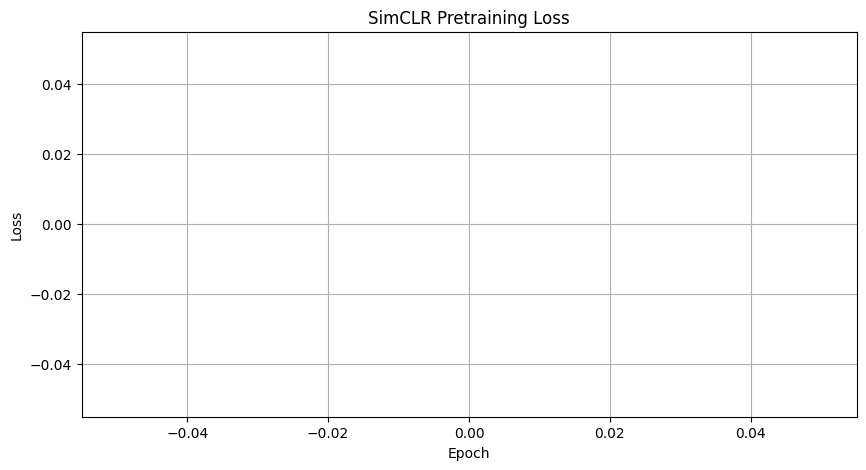

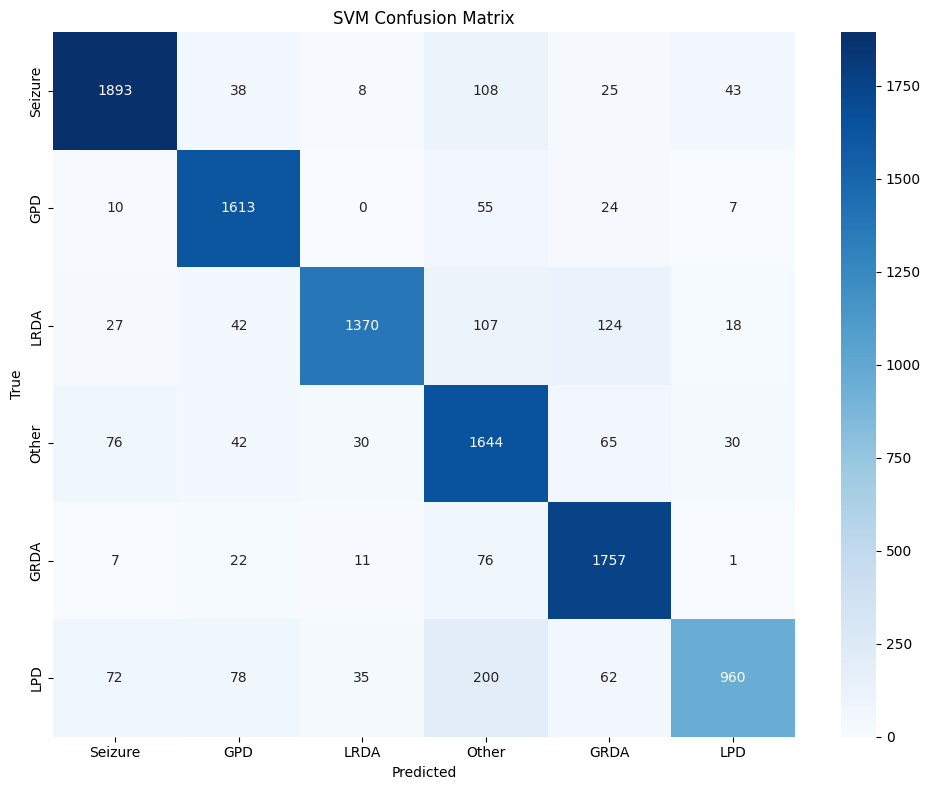

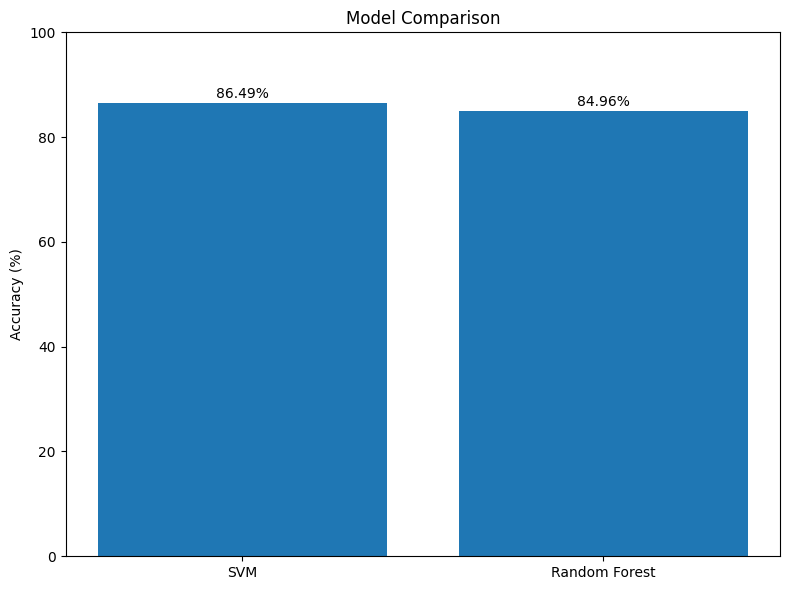

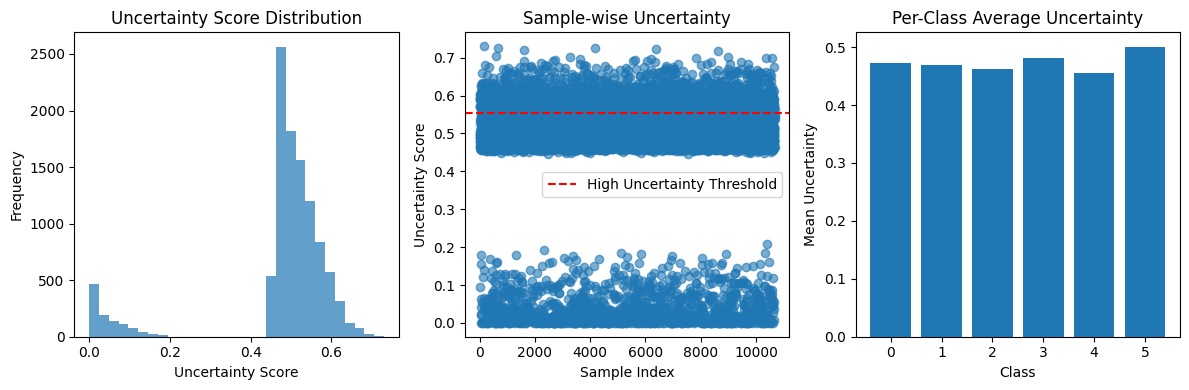


CALCULATING COMPREHENSIVE METRICS
Calculating comprehensive metrics...
Computing performance metrics...
Computing probability-based metrics...
Computing calibration metrics...
Computing per-class metrics...
Computing efficiency metrics...
Computing robustness metrics...
Comprehensive metrics calculation completed in 3923.87 seconds

COMPREHENSIVE MODEL EVALUATION SUMMARY
Training Period: 2025-06-22T17:02:20.857115 to 2025-06-22T19:02:20.857123
Evaluation Timestamp: 2025-06-22T19:02:20.857133

📊 PERFORMANCE METRICS
────────────────────────────────────────
Accuracy: 0.8649
Balanced Accuracy: 0.8569
Precision (Macro): 0.8734
Recall (Macro): 0.8569
F1-Score (Macro): 0.8605
AUC-ROC (Macro): 0.9723
Cohen's Kappa: 0.8371
Matthews Correlation: 0.8385

🎯 PROBABILITY-BASED METRICS
────────────────────────────────────────
Log Loss: 0.6104
Brier Score: 0.0493
Average Precision: 0.8805

🎯 CALIBRATION METRICS
────────────────────────────────────────
Expected Calibration Error: 0.2058

⚡ EFFICIENCY 

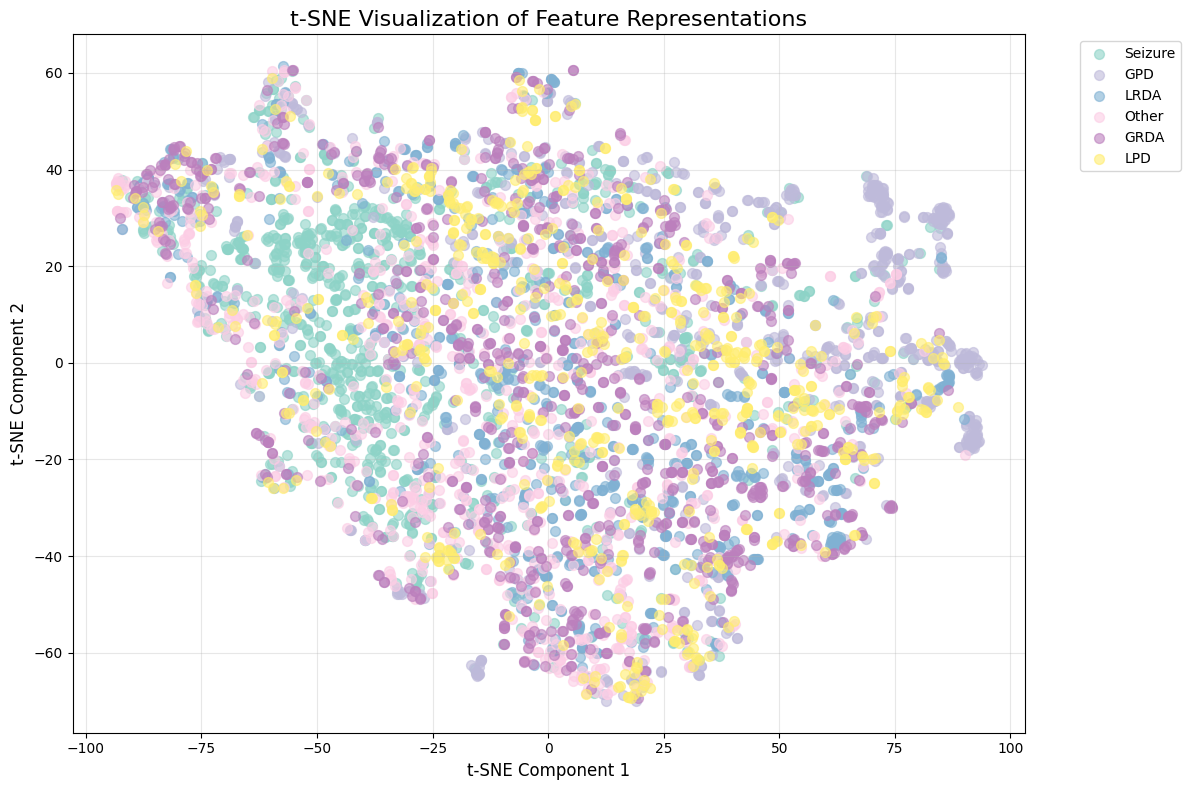

t-SNE visualization saved to tsne_test_features.png

Creating t-SNE visualization for training features...
Creating t-SNE visualization...


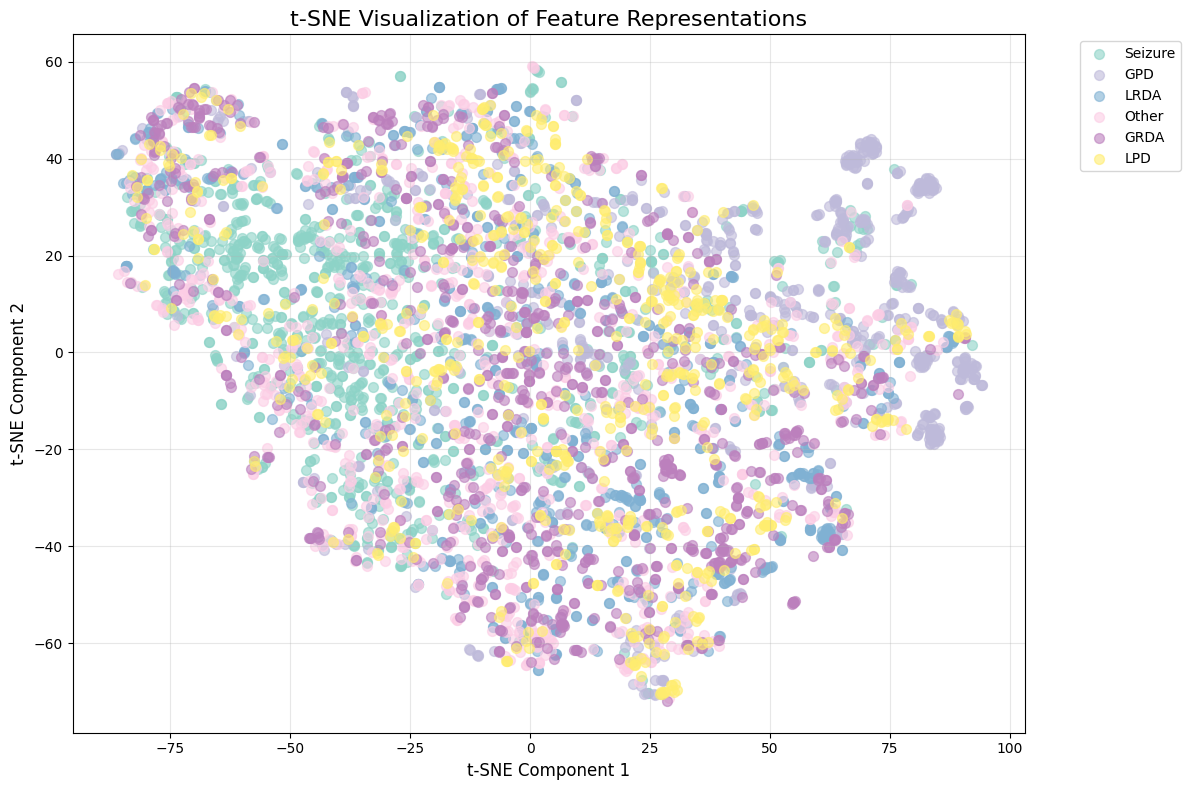

t-SNE visualization saved to tsne_train_features.png

Creating reliability diagram...


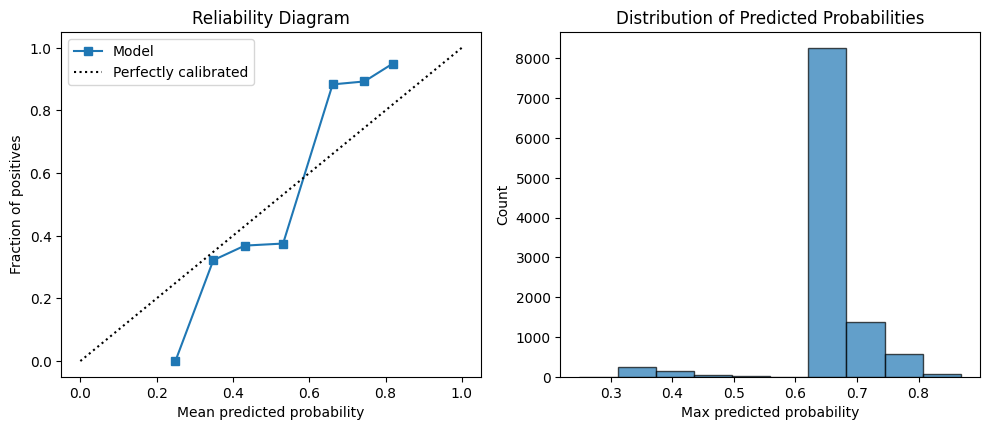

Reliability diagram saved to reliability_diagram.png

Saving comprehensive results...
Comprehensive results saved to: comprehensive_results_20250622_202249.json

Creating confusion matrix visualization...


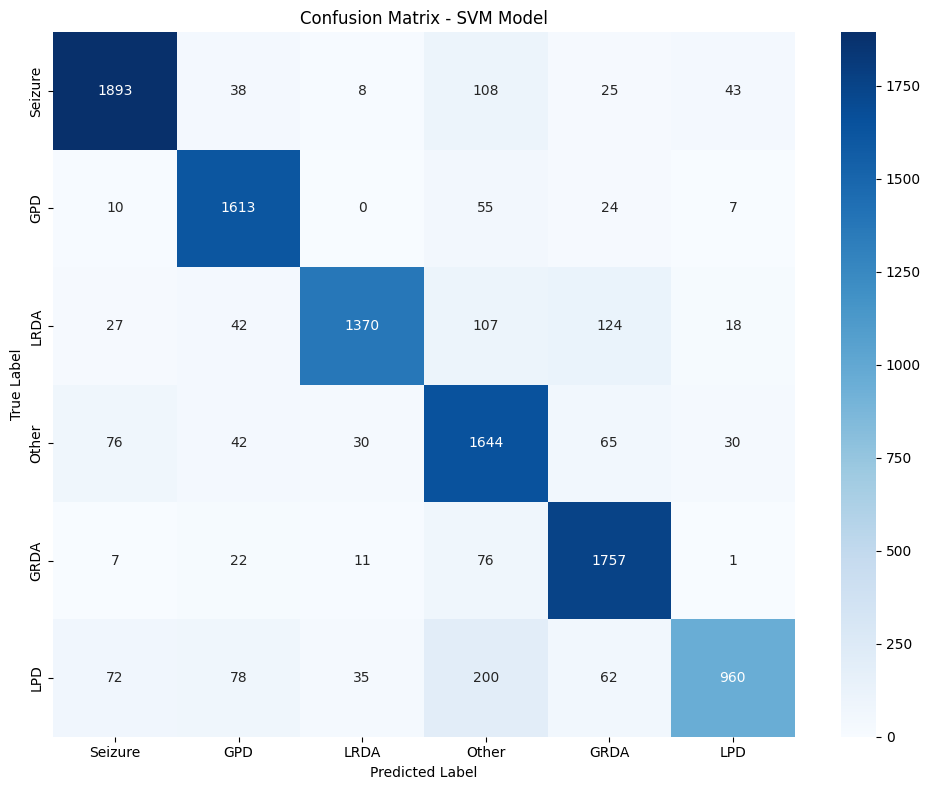


Creating performance metrics visualization...


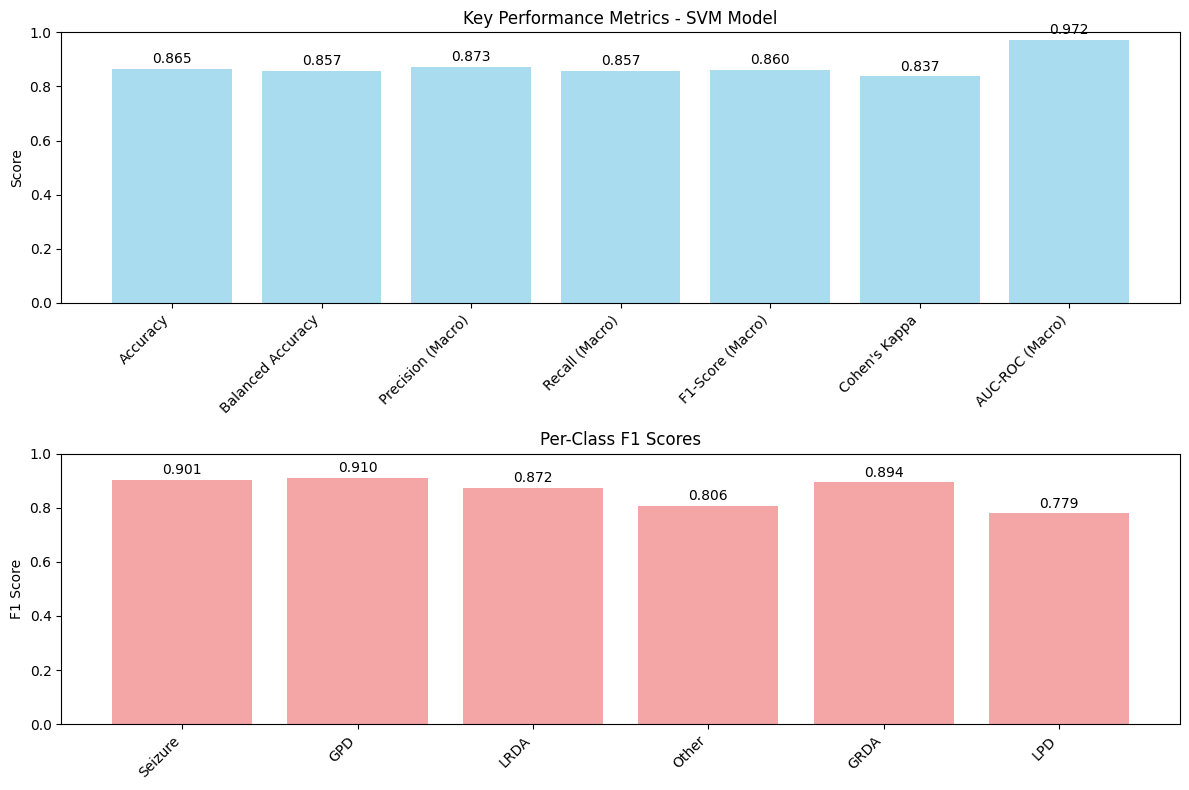


GENERATING FINAL EVALUATION REPORT
Final evaluation report saved to: svm_evaluation_report_20250622_203653.txt

Comprehensive evaluation completed successfully!
Generated files:
- comprehensive_results_20250622_202249.json (detailed JSON results)
- svm_evaluation_report_20250622_203653.txt (summary report)
- tsne_test_features.png
- tsne_train_features.png (if applicable)
- reliability_diagram.png
- confusion_matrix_svm.png
- performance_metrics_summary.png

HYPERPARAMETER ANALYSIS
Best SVM hyperparameters:
  memory: None
  steps: [('scaler', StandardScaler()), ('svm', SVC(C=45, class_weight='balanced'))]
  verbose: False
  scaler: StandardScaler()
  svm: SVC(C=45, class_weight='balanced')
  scaler__copy: True
  scaler__with_mean: True
  scaler__with_std: True
  svm__C: 45
  svm__break_ties: False
  svm__cache_size: 200
  svm__class_weight: balanced
  svm__coef0: 0.0
  svm__decision_function_shape: ovr
  svm__degree: 3
  svm__gamma: scale
  svm__kernel: rbf
  svm__max_iter: -1
  svm__

In [9]:
if __name__ == "__main__":
    main()